In [1]:
import warnings
import os
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

torch.cuda.empty_cache()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

warnings.filterwarnings("ignore")

In [2]:
TRAIN_IMG_DIR = "datasets/kvasir_capsule/train/images"
TRAIN_MASK_DIR = "datasets/kvasir_capsule/train/masks"
VAL_IMG_DIR = "datasets/kvasir_capsule/test/images"
VAL_MASK_DIR = "datasets/kvasir_capsule/test/masks"

In [3]:
class BloodCellDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None) -> None:
        super(BloodCellDataset, self).__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(
            self.mask_dir, self.images[index])

        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),
                        dtype=np.float32)
        # mask[mask == 255.0] = 1.0
        mask = np.where(mask > 155.0, 1.0, 0.0)

        if self.transform is not None:
            augemantations = self.transform(image=image, mask=mask)
            image = augemantations['image']
            mask = augemantations['mask']
        return image, mask

In [4]:
def get_data_loaders(
        train_dir, train_mask_dir, val_dir, val_maskdir, batch_size,
        train_transform, val_transform):

    train_ds = BloodCellDataset(
        image_dir=train_dir, mask_dir=train_mask_dir,
        transform=train_transform)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
    )

    val_ds = BloodCellDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

In [5]:
train_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [6]:
BATCH_SIZE = 2

train_loader, val_loader = get_data_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms
)

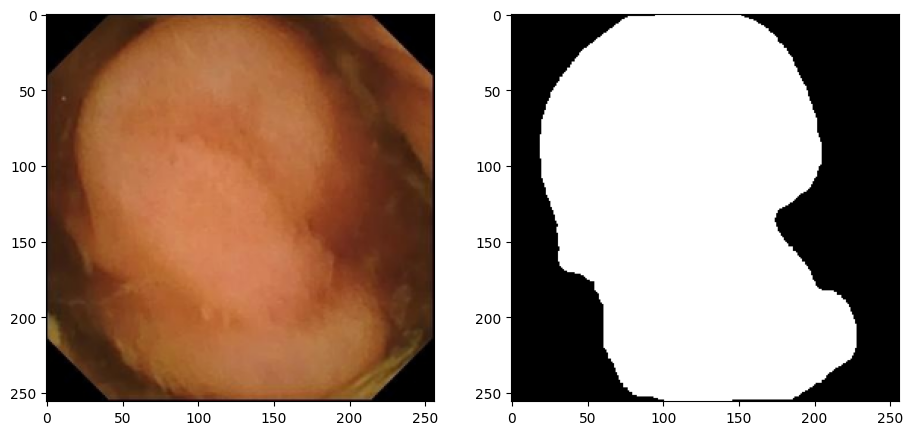

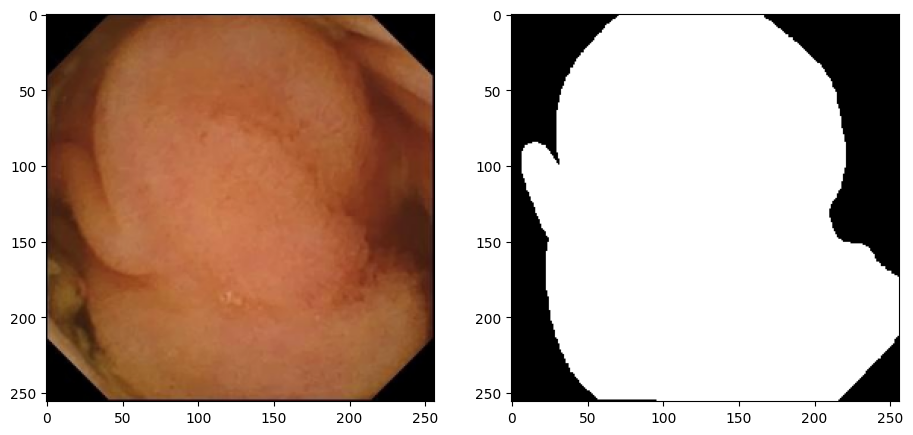

In [7]:
def show_transformed(data_loader):
    batch = next(iter(data_loader))
    images, labels = batch

    for img, mask in zip(images, labels):
        plt.figure(figsize=(11, 11))

        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(img, (1, 2, 0)))

        plt.subplot(1, 2, 2)
        # plt.imshow(mask.reshape(mask.shape[0], mask.shape[1], 1))
        plt.imshow(mask, cmap="gray")

show_transformed(val_loader)

In [8]:
train_loader.dataset[0][0].shape
train_loader.dataset[0][1].shape

torch.Size([256, 256])

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.convBlock = nn.Sequential(

            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.convBlock(x)

In [10]:
class DownTransition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownTransition, self).__init__()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv_block(x)

        return x

In [11]:
class UpTransition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpTransition, self).__init__()

        self.up = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)  # x2 = skip connection
        x = self.conv_block(x)

        return x

In [12]:
class VNet(nn.Module):
    def __init__(self, n_classes, n_channels):
        super(VNet, self).__init__()
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.input = ConvBlock(n_channels, 16)

        self.down1 = DownTransition(16, 32)
        self.down2 = DownTransition(32, 64)
        self.down3 = DownTransition(64, 128)
        self.down4 = DownTransition(128, 256)

        self.up4 = UpTransition(256, 128)
        self.up3 = UpTransition(128, 64)
        self.up2 = UpTransition(64, 32)
        self.up1 = UpTransition(32, 16)

        self.output = nn.Conv2d(16, n_classes, kernel_size=1)

    def forward(self, x):
        input = self.input(x)

        down1 = self.down1(input)
        down2 = self.down2(down1)
        down3 = self.down3(down2)

        down4 = self.down4(down3)

        up4 = self.up4(down4, down3)
        up3 = self.up3(up4, down2)
        up2 = self.up2(up3, down1)
        up1 = self.up1(up2, input)

        output = self.output(up1)
        return output

In [13]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce_losss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets, smooth=1):
        BCE = self.bce_losss(inputs, targets)
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(
            inputs.sum() + targets.sum() + smooth)
        Dice_BCE = BCE + dice_loss
        return Dice_BCE
    
class IOU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IOU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)
        return IoU

In [14]:
model = VNet(n_classes=1, n_channels=3).to(DEVICE)
loss_fn = DiceBCELoss()

iou_fn = IOU()
scaler = torch.cuda.amp.GradScaler()
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_iou = []
train_loss = []
train_dice = []

def save_checkpoint(state, filename="model_VNet.pth.tar"):
    print("=> Saving checkpoint")
    # torch.save(state, filename)

In [15]:
model

VNet(
  (input): ConvBlock(
    (convBlock): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): DownTransition(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block): ConvBlock(
      (convBlock): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_

In [16]:
print(model)

VNet(
  (input): ConvBlock(
    (convBlock): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): DownTransition(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block): ConvBlock(
      (convBlock): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_

In [17]:
start_time = time.time()

# let's train it just for 2 epochs
NUM_EPOCHS = 32

for epoch in range(NUM_EPOCHS):
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}")

    iterations = 0
    iter_loss = 0.0
    iter_iou = 0.0

    batch_loop = tqdm(train_loader)
    for batch_idx, (data, targets) in enumerate(batch_loop):

        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        with torch.autocast(device_type=DEVICE, dtype=torch.bfloat16):
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            iou = iou_fn(predictions, targets)

            iter_loss += loss.item()
            iter_iou += iou.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        iterations += 1
        batch_loop.set_postfix(diceloss=loss.item(), iou=iou.item())

    train_loss.append(iter_loss / iterations)
    train_iou.append(iter_iou / iterations)
    # print(
    #     f"Epoch: {epoch+1}/{NUM_EPOCHS}, Training loss: {round(train_loss[-1] , 3)}")
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, IoU score: {iter_iou / iterations}")

    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    # save_checkpoint(checkpoint)

    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    # print(
    #     f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    # )
    print(
        f"Epoch: {epoch+1}/{NUM_EPOCHS}, Total num_correct/num_pixels: {num_correct}/{num_pixels} => {num_correct/num_pixels}"
    )
    print(
        f"Epoch: {epoch+1}/{NUM_EPOCHS}, Dice score: {dice_score / len(val_loader)}")
    train_dice.append(dice_score / len(val_loader))
    model.train()

print("done ..")

end_time = time.time()
training_time = end_time - start_time
print(
    f"The training time of the VNET model is: {training_time:.2f} seconds")

Epoch: 1/32


100%|██████████| 22/22 [00:03<00:00,  5.84it/s, diceloss=1.06, iou=0.441]


Epoch: 1/32, IoU score: 0.36001858792521735
Epoch: 1/32, Total num_correct/num_pixels: 292131/720896 => 0.405233234167099
Epoch: 1/32, Dice score: 0.0
Epoch: 2/32


100%|██████████| 22/22 [00:03<00:00,  6.31it/s, diceloss=0.893, iou=0.447]


Epoch: 2/32, IoU score: 0.4364787705919959
Epoch: 2/32, Total num_correct/num_pixels: 653209/720896 => 0.9061071276664734
Epoch: 2/32, Dice score: 0.9177872985910259
Epoch: 3/32


100%|██████████| 22/22 [00:03<00:00,  6.55it/s, diceloss=0.814, iou=0.512]


Epoch: 3/32, IoU score: 0.4829412197524851
Epoch: 3/32, Total num_correct/num_pixels: 668975/720896 => 0.9279771447181702
Epoch: 3/32, Dice score: 0.9362956587570072
Epoch: 4/32


100%|██████████| 22/22 [00:03<00:00,  6.33it/s, diceloss=0.747, iou=0.536]


Epoch: 4/32, IoU score: 0.5103448548100211
Epoch: 4/32, Total num_correct/num_pixels: 670613/720896 => 0.9302493333816528
Epoch: 4/32, Dice score: 0.9402813584370616
Epoch: 5/32


100%|██████████| 22/22 [00:03<00:00,  6.19it/s, diceloss=0.745, iou=0.543]


Epoch: 5/32, IoU score: 0.5240081927993081
Epoch: 5/32, Total num_correct/num_pixels: 668242/720896 => 0.9269603490829468
Epoch: 5/32, Dice score: 0.9394965820530787
Epoch: 6/32


100%|██████████| 22/22 [00:03<00:00,  6.33it/s, diceloss=0.729, iou=0.529]


Epoch: 6/32, IoU score: 0.5346853719516234
Epoch: 6/32, Total num_correct/num_pixels: 665029/720896 => 0.9225034117698669
Epoch: 6/32, Dice score: 0.9371822054078025
Epoch: 7/32


100%|██████████| 22/22 [00:03<00:00,  6.12it/s, diceloss=0.716, iou=0.549]


Epoch: 7/32, IoU score: 0.5418998720971021
Epoch: 7/32, Total num_correct/num_pixels: 667080/720896 => 0.9253484606742859
Epoch: 7/32, Dice score: 0.939797155780373
Epoch: 8/32


100%|██████████| 22/22 [00:03<00:00,  6.15it/s, diceloss=0.675, iou=0.545]


Epoch: 8/32, IoU score: 0.5490718998692252
Epoch: 8/32, Total num_correct/num_pixels: 681049/720896 => 0.944725751876831
Epoch: 8/32, Dice score: 0.9547468932838472
Epoch: 9/32


100%|██████████| 22/22 [00:03<00:00,  6.35it/s, diceloss=0.722, iou=0.571]


Epoch: 9/32, IoU score: 0.5567744076251984
Epoch: 9/32, Total num_correct/num_pixels: 674069/720896 => 0.9350433349609375
Epoch: 9/32, Dice score: 0.9475883482153377
Epoch: 10/32


100%|██████████| 22/22 [00:03<00:00,  6.34it/s, diceloss=0.646, iou=0.572]


Epoch: 10/32, IoU score: 0.5669128054922278
Epoch: 10/32, Total num_correct/num_pixels: 664746/720896 => 0.9221108555793762
Epoch: 10/32, Dice score: 0.9380385347072198
Epoch: 11/32


100%|██████████| 22/22 [00:03<00:00,  6.36it/s, diceloss=0.643, iou=0.551]


Epoch: 11/32, IoU score: 0.5739759504795074
Epoch: 11/32, Total num_correct/num_pixels: 665461/720896 => 0.9231026768684387
Epoch: 11/32, Dice score: 0.9402740933745366
Epoch: 12/32


100%|██████████| 22/22 [00:03<00:00,  6.31it/s, diceloss=0.621, iou=0.591]


Epoch: 12/32, IoU score: 0.5782623426480726
Epoch: 12/32, Total num_correct/num_pixels: 656528/720896 => 0.9107111692428589
Epoch: 12/32, Dice score: 0.928557928206677
Epoch: 13/32


100%|██████████| 22/22 [00:03<00:00,  6.33it/s, diceloss=0.599, iou=0.596]


Epoch: 13/32, IoU score: 0.587220311164856
Epoch: 13/32, Total num_correct/num_pixels: 677933/720896 => 0.9404033422470093
Epoch: 13/32, Dice score: 0.951237872804914
Epoch: 14/32


100%|██████████| 22/22 [00:03<00:00,  6.36it/s, diceloss=0.626, iou=0.589]


Epoch: 14/32, IoU score: 0.5901677337559786
Epoch: 14/32, Total num_correct/num_pixels: 678504/720896 => 0.9411954283714294
Epoch: 14/32, Dice score: 0.9518980954551709
Epoch: 15/32


100%|██████████| 22/22 [00:03<00:00,  6.28it/s, diceloss=0.6, iou=0.581]  


Epoch: 15/32, IoU score: 0.5997962626543912
Epoch: 15/32, Total num_correct/num_pixels: 663982/720896 => 0.921051025390625
Epoch: 15/32, Dice score: 0.9363194411515812
Epoch: 16/32


100%|██████████| 22/22 [00:03<00:00,  6.33it/s, diceloss=0.57, iou=0.625] 


Epoch: 16/32, IoU score: 0.6072921725836667
Epoch: 16/32, Total num_correct/num_pixels: 673330/720896 => 0.9340182542800903
Epoch: 16/32, Dice score: 0.9467851040727263
Epoch: 17/32


100%|██████████| 22/22 [00:03<00:00,  6.31it/s, diceloss=0.576, iou=0.615]


Epoch: 17/32, IoU score: 0.610356637022712
Epoch: 17/32, Total num_correct/num_pixels: 662002/720896 => 0.918304443359375
Epoch: 17/32, Dice score: 0.9353919048836377
Epoch: 18/32


100%|██████████| 22/22 [00:03<00:00,  6.31it/s, diceloss=0.597, iou=0.614]


Epoch: 18/32, IoU score: 0.6178995099934664
Epoch: 18/32, Total num_correct/num_pixels: 651245/720896 => 0.9033827781677246
Epoch: 18/32, Dice score: 0.9222087568879501
Epoch: 19/32


100%|██████████| 22/22 [00:03<00:00,  6.32it/s, diceloss=0.568, iou=0.628]


Epoch: 19/32, IoU score: 0.6232278726317666
Epoch: 19/32, Total num_correct/num_pixels: 674479/720896 => 0.9356120824813843
Epoch: 19/32, Dice score: 0.9480593933614516
Epoch: 20/32


100%|██████████| 22/22 [00:03<00:00,  6.32it/s, diceloss=0.542, iou=0.631]


Epoch: 20/32, IoU score: 0.6327848813750527
Epoch: 20/32, Total num_correct/num_pixels: 676257/720896 => 0.9380784630775452
Epoch: 20/32, Dice score: 0.9505426002910575
Epoch: 21/32


100%|██████████| 22/22 [00:03<00:00,  6.18it/s, diceloss=0.541, iou=0.634]


Epoch: 21/32, IoU score: 0.6338930075818842
Epoch: 21/32, Total num_correct/num_pixels: 666503/720896 => 0.9245480895042419
Epoch: 21/32, Dice score: 0.940166129987759
Epoch: 22/32


100%|██████████| 22/22 [00:03<00:00,  6.31it/s, diceloss=0.528, iou=0.656]


Epoch: 22/32, IoU score: 0.6433068920265544
Epoch: 22/32, Total num_correct/num_pixels: 671490/720896 => 0.9314658641815186
Epoch: 22/32, Dice score: 0.9459070282227124
Epoch: 23/32


100%|██████████| 22/22 [00:03<00:00,  6.34it/s, diceloss=0.507, iou=0.642]


Epoch: 23/32, IoU score: 0.6503202454610304
Epoch: 23/32, Total num_correct/num_pixels: 670562/720896 => 0.9301785826683044
Epoch: 23/32, Dice score: 0.9436945858081832
Epoch: 24/32


100%|██████████| 22/22 [00:03<00:00,  6.35it/s, diceloss=0.492, iou=0.656]


Epoch: 24/32, IoU score: 0.6507161611860449
Epoch: 24/32, Total num_correct/num_pixels: 651284/720896 => 0.9034368395805359
Epoch: 24/32, Dice score: 0.9231775715431758
Epoch: 25/32


100%|██████████| 22/22 [00:03<00:00,  6.35it/s, diceloss=0.492, iou=0.675]


Epoch: 25/32, IoU score: 0.6577055589719252
Epoch: 25/32, Total num_correct/num_pixels: 673736/720896 => 0.934581458568573
Epoch: 25/32, Dice score: 0.9474742943387062
Epoch: 26/32


100%|██████████| 22/22 [00:03<00:00,  6.12it/s, diceloss=0.466, iou=0.663]


Epoch: 26/32, IoU score: 0.6653100170872428
Epoch: 26/32, Total num_correct/num_pixels: 675369/720896 => 0.9368466734886169
Epoch: 26/32, Dice score: 0.9486269249132464
Epoch: 27/32


100%|██████████| 22/22 [00:03<00:00,  6.17it/s, diceloss=0.448, iou=0.676]


Epoch: 27/32, IoU score: 0.6676785376938906
Epoch: 27/32, Total num_correct/num_pixels: 671507/720896 => 0.9314894676208496
Epoch: 27/32, Dice score: 0.9456139576193792
Epoch: 28/32


100%|██████████| 22/22 [00:03<00:00,  6.31it/s, diceloss=0.448, iou=0.665]


Epoch: 28/32, IoU score: 0.6784379455176267
Epoch: 28/32, Total num_correct/num_pixels: 681295/720896 => 0.9450669884681702
Epoch: 28/32, Dice score: 0.9551236252403191
Epoch: 29/32


100%|██████████| 22/22 [00:03<00:00,  6.35it/s, diceloss=0.433, iou=0.689]


Epoch: 29/32, IoU score: 0.6792479428378019
Epoch: 29/32, Total num_correct/num_pixels: 671276/720896 => 0.9311690330505371
Epoch: 29/32, Dice score: 0.9450151691056881
Epoch: 30/32


100%|██████████| 22/22 [00:03<00:00,  6.35it/s, diceloss=0.44, iou=0.699] 


Epoch: 30/32, IoU score: 0.6846927892078053
Epoch: 30/32, Total num_correct/num_pixels: 675022/720896 => 0.9363653063774109
Epoch: 30/32, Dice score: 0.9487209266639566
Epoch: 31/32


100%|██████████| 22/22 [00:03<00:00,  6.32it/s, diceloss=0.467, iou=0.658]


Epoch: 31/32, IoU score: 0.689497939564965
Epoch: 31/32, Total num_correct/num_pixels: 680260/720896 => 0.9436312913894653
Epoch: 31/32, Dice score: 0.9555286727307226
Epoch: 32/32


100%|██████████| 22/22 [00:03<00:00,  6.37it/s, diceloss=0.408, iou=0.708]


Epoch: 32/32, IoU score: 0.6961928822777488
Epoch: 32/32, Total num_correct/num_pixels: 673361/720896 => 0.9340612292289734
Epoch: 32/32, Dice score: 0.9469847317437808
done ..
The training time of the VNET model is: 116.23 seconds


In [18]:
print(train_loss)

[1.2175284569913691, 0.9771760349923914, 0.8553197221322493, 0.7899188995361328, 0.7577123235572468, 0.7329016652974215, 0.7171069112691012, 0.7028216340325095, 0.6861006427894939, 0.6639252386309884, 0.6485250998627056, 0.6412863568826155, 0.6220451972701333, 0.6174476336349141, 0.5973944934931669, 0.5839133967052806, 0.5776828879659827, 0.5644848211245104, 0.5538315583359111, 0.5346822901205583, 0.5336161960255016, 0.5151942981915041, 0.5022853165864944, 0.502379674803127, 0.49023831297050824, 0.4758398505774411, 0.4716894734989513, 0.4521020434119485, 0.45086113295771857, 0.4410746937448328, 0.4343137768181888, 0.42206213961948047]


In [19]:
print(train_iou)

[0.36001858792521735, 0.4364787705919959, 0.4829412197524851, 0.5103448548100211, 0.5240081927993081, 0.5346853719516234, 0.5418998720971021, 0.5490718998692252, 0.5567744076251984, 0.5669128054922278, 0.5739759504795074, 0.5782623426480726, 0.587220311164856, 0.5901677337559786, 0.5997962626543912, 0.6072921725836667, 0.610356637022712, 0.6178995099934664, 0.6232278726317666, 0.6327848813750527, 0.6338930075818842, 0.6433068920265544, 0.6503202454610304, 0.6507161611860449, 0.6577055589719252, 0.6653100170872428, 0.6676785376938906, 0.6784379455176267, 0.6792479428378019, 0.6846927892078053, 0.689497939564965, 0.6961928822777488]


In [20]:
print(train_dice)

[tensor(0., device='cuda:0', dtype=torch.float64), tensor(0.9178, device='cuda:0', dtype=torch.float64), tensor(0.9363, device='cuda:0', dtype=torch.float64), tensor(0.9403, device='cuda:0', dtype=torch.float64), tensor(0.9395, device='cuda:0', dtype=torch.float64), tensor(0.9372, device='cuda:0', dtype=torch.float64), tensor(0.9398, device='cuda:0', dtype=torch.float64), tensor(0.9547, device='cuda:0', dtype=torch.float64), tensor(0.9476, device='cuda:0', dtype=torch.float64), tensor(0.9380, device='cuda:0', dtype=torch.float64), tensor(0.9403, device='cuda:0', dtype=torch.float64), tensor(0.9286, device='cuda:0', dtype=torch.float64), tensor(0.9512, device='cuda:0', dtype=torch.float64), tensor(0.9519, device='cuda:0', dtype=torch.float64), tensor(0.9363, device='cuda:0', dtype=torch.float64), tensor(0.9468, device='cuda:0', dtype=torch.float64), tensor(0.9354, device='cuda:0', dtype=torch.float64), tensor(0.9222, device='cuda:0', dtype=torch.float64), tensor(0.9481, device='cuda:0',

In [21]:
train_dice = [t.cpu().item() for t in train_dice]

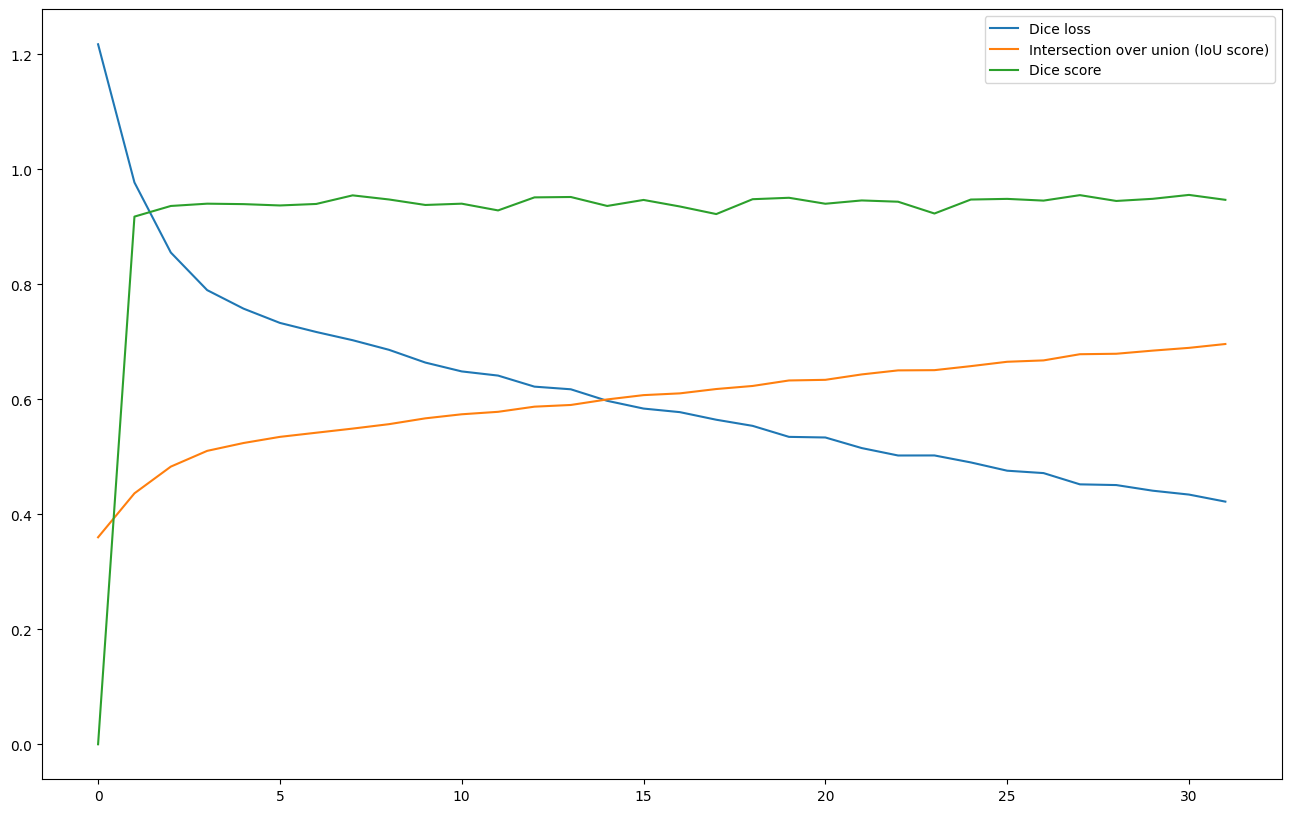

In [22]:
f = plt.figure(figsize=(16, 10))
plt.plot(train_loss, label='Dice loss')
plt.plot(train_iou, label='Intersection over union (IoU score)')
plt.plot(train_dice, label='Dice score')
plt.legend()
plt.show()

In [23]:
def test_model(model, val_loader, device):
    model.eval()
    dice_score = 0
    iou_metric = IOU()
    iou_score = 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Testing"):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)

            preds = torch.sigmoid(model(x))
            preds_binary = (preds > 0.5).float()

            dice_score += (2 * (preds_binary * y).sum()) / (
                (preds_binary + y).sum() + 1e-8
            )
            iou_score += iou_metric(preds_binary, y)

    avg_dice = dice_score / len(val_loader)
    avg_iou = iou_score / len(val_loader)

    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU Score: {avg_iou:.4f}")

    return avg_dice, avg_iou

avg_dice, avg_iou = test_model(model, val_loader, DEVICE)

Testing: 100%|██████████| 6/6 [00:00<00:00, 33.13it/s]

Average Dice Score: 0.9470
Average IoU Score: 0.5235


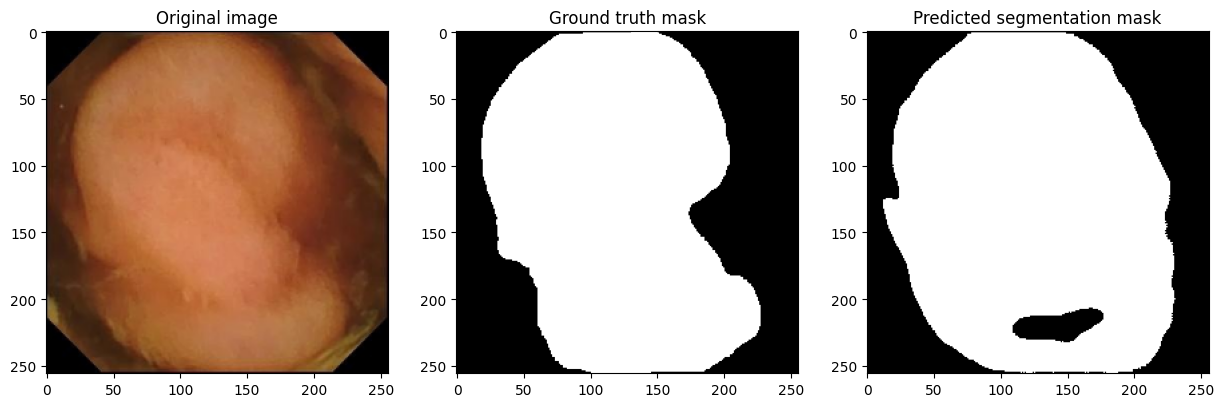

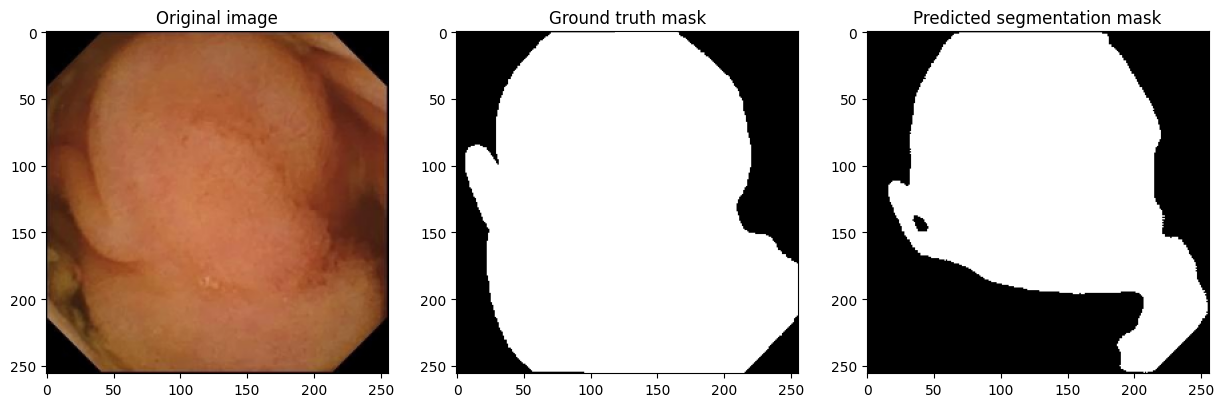

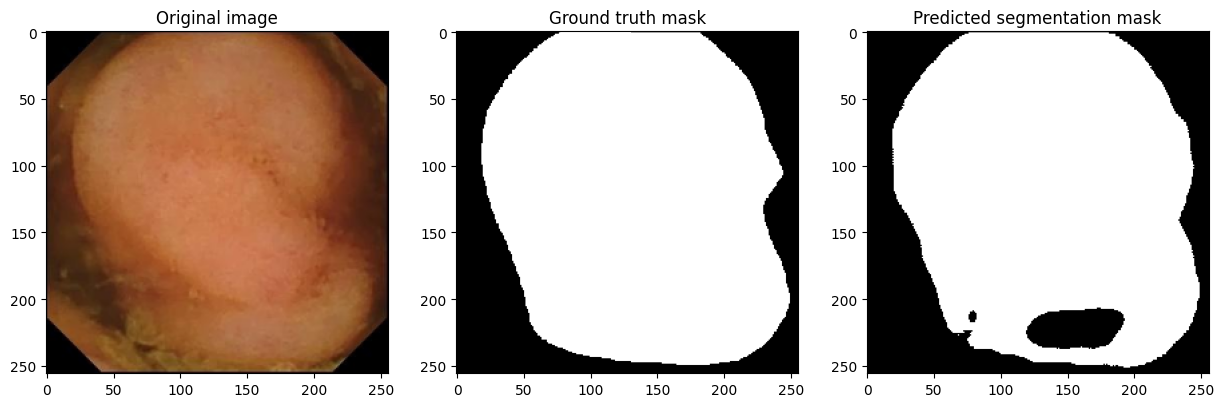

In [24]:
def visualize_predictions(model, val_loader, device, num_samples=3):
    model.eval()
    samples = 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds_binary = (preds > 0.5).float()

            for i in range(x.size(0)):
                if samples >= num_samples:
                    break

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.title("Original image")
                plt.imshow(np.transpose(x[i].cpu().numpy(), (1, 2, 0)))

                plt.subplot(1, 3, 2)
                plt.title("Ground truth mask")
                plt.imshow(y[i].cpu().numpy().squeeze(), cmap="gray")

                plt.subplot(1, 3, 3)
                plt.title("Predicted segmentation mask")
                plt.imshow(preds_binary[i].cpu(
                ).numpy().squeeze(), cmap="gray")

                plt.show()
                samples += 1

            if samples >= num_samples:
                break
            
visualize_predictions(model, val_loader, DEVICE)

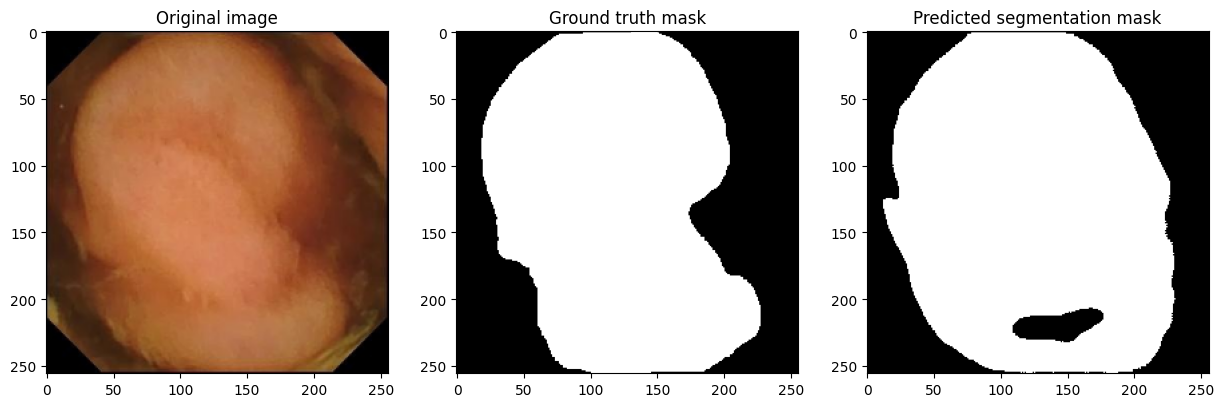

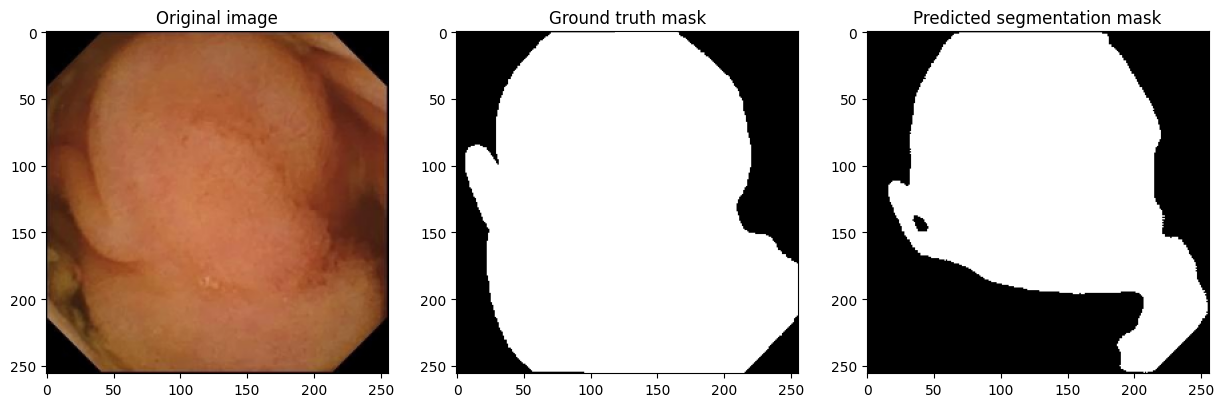

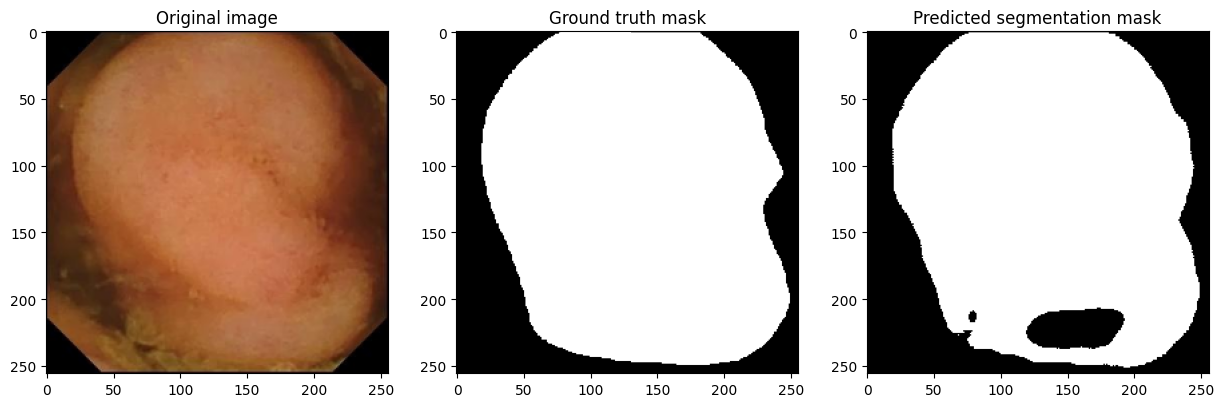

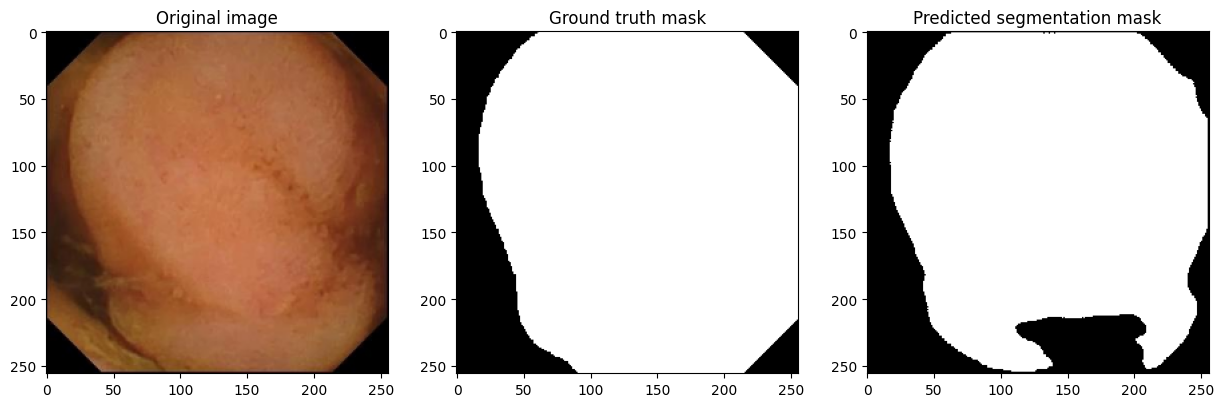

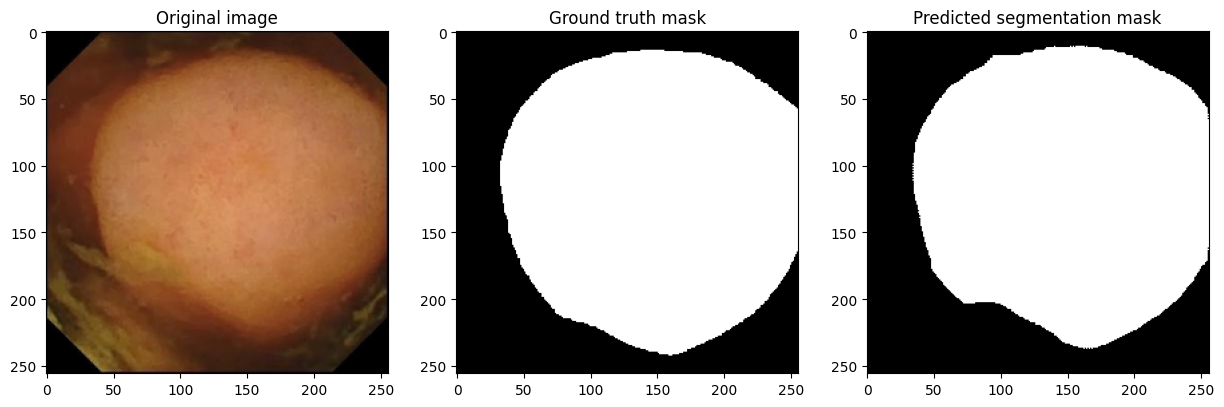

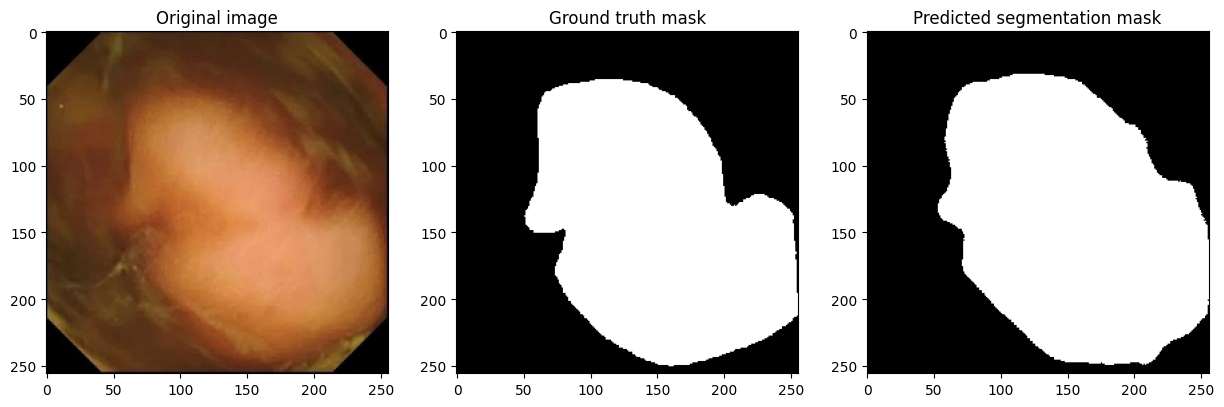

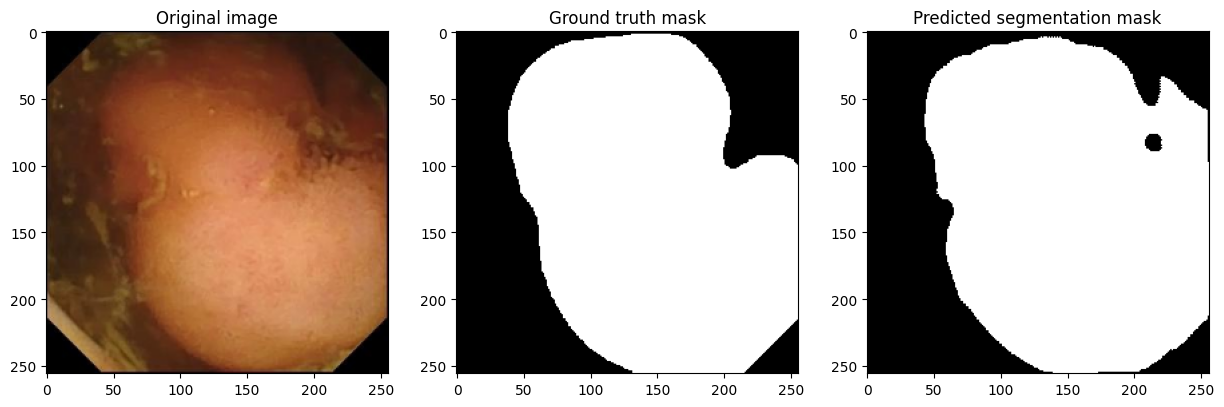

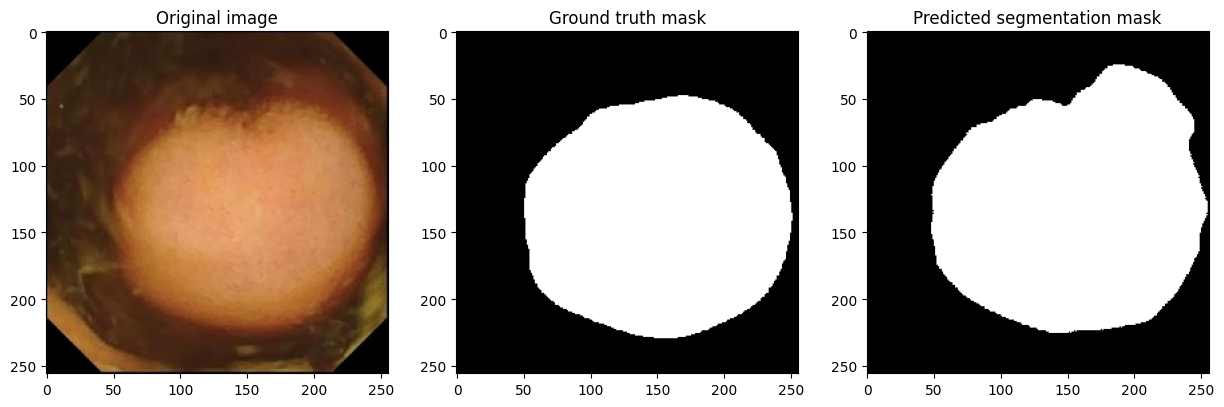

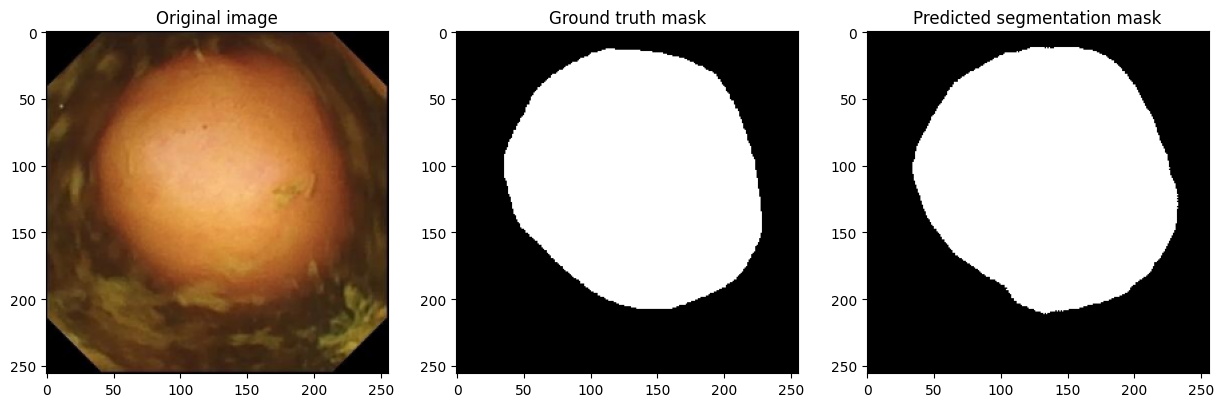

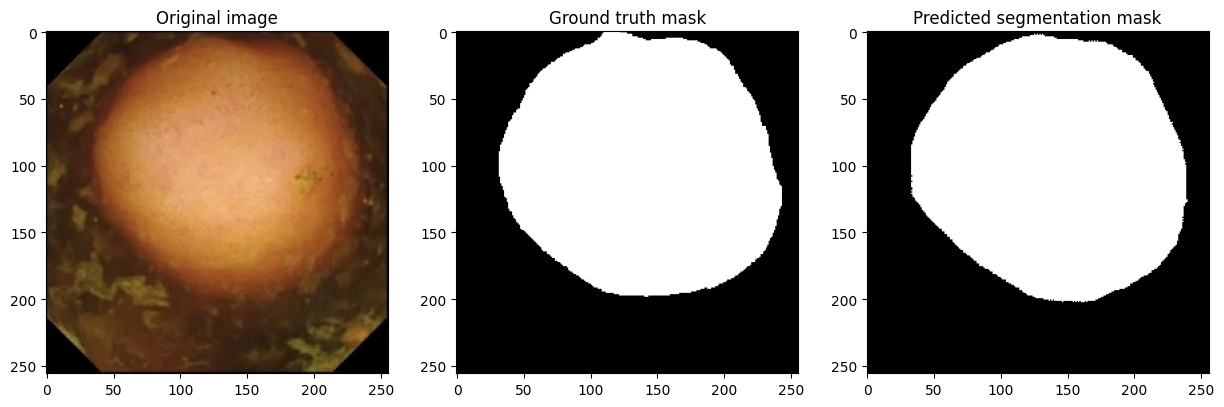

In [25]:
visualize_predictions(model, val_loader, DEVICE, num_samples=10)

In [26]:
# visualize_predictions(model, val_loader, DEVICE, num_samples=50)

In [27]:
# visualize_predictions(model, val_loader, DEVICE, num_samples=100)